Credit card fraud detection refers to the process of identifying fraudulent transactions on a credit card account in real-time or post-transaction. It's a critical task for financial institutions, retailers, and cardholders, as it helps prevent financial loss and unauthorized use of credit cards. Given the complexity and the ever-evolving nature of fraudulent activities, advanced machine learning algorithms are often employed to detect anomalies and patterns indicative of fraud.

The data for this study is obtained from [kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data). It presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Due to confidentiality issues, the original features are not provided. Instead, it consists of numerical input variables which are the result of a PCA transformation.

The only features which have not been transformed with PCA are 'Time' and 'Amount'.

# Importing the data and libraries

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score



In [2]:
data = pd.read_csv("creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory data analysis

In [4]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


Checking for the data type for each feature

In [5]:
data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

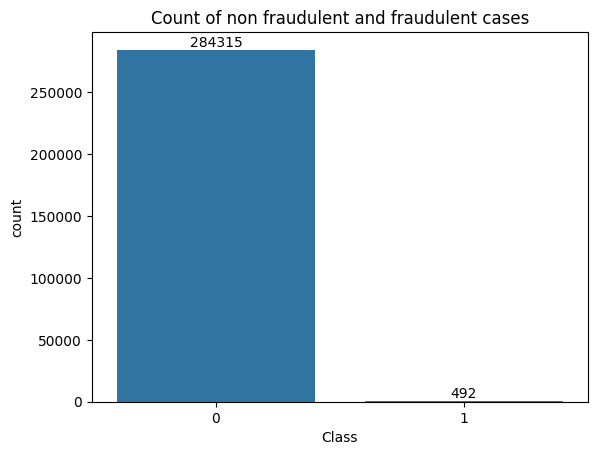

In [6]:
ax = sns.countplot(data=data, x='Class')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position at top of bar
                ha='center', va='bottom', fontsize=10)

plt.title("Count of non fraudulent and fraudulent cases")
plt.show()

There are 284,807 rows, with only 492 fraudulent cases, which makes the dataset highly imbalanced. The fraudulent cases make up approximately 0.173% of the total data, meaning most transactions are legitimate.

<function matplotlib.pyplot.show(close=None, block=None)>

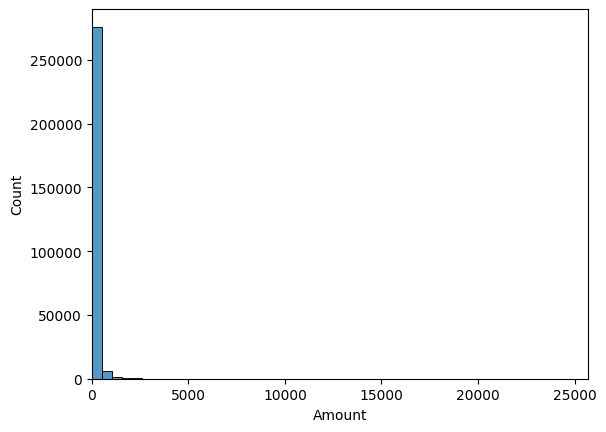

In [7]:
amount_values = data['Amount'].values

sns.histplot(data=data, x='Amount', bins=50)
plt.xlim(min(amount_values), max(amount_values))
plt.show


The "Amount" variable in the dataset is skewed. This is common in financial transaction data, where most purchases are small amounts, but some high-value transactions exist.

<function matplotlib.pyplot.show(close=None, block=None)>

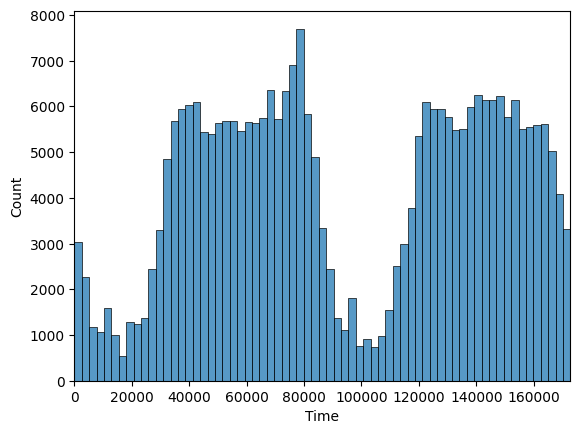

In [8]:
time_values = data['Time'].values

sns.histplot(data=data, x='Time')
plt.xlim(min(time_values), max(time_values))
# plt.ylim(0, 1000)
plt.show

The histogram of time shows two peaks, it may indicate

* Different periods of high transaction activity.
* A shift-based pattern (e.g., business hours vs. after-hours).
* Potential fraud patterns occurring at specific time windows.

In [9]:
# checking for missing values

data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There are no missing values in the dataset, hence there's no need for imputation. The next steps are feature engineering, data transformation, handling imbalance, and model selection.

In [10]:
print(f'The minimum of Amount variable is {min(amount_values)} and the maximum is {max(amount_values)}')
print(f'The minimum of Time variable is {min(time_values)} and the maximum is {max(time_values)}')

The minimum of Amount variable is 0.0 and the maximum is 25691.16
The minimum of Time variable is 0.0 and the maximum is 172792.0


# XGBoost

XGBoost is effective for highly imbalanced classes because it offers built-in regularization to reduce overfitting, supports class and sample weighting to prioritize the minority class, and uses boosting to focus on hard-to-classify examples. Its decision tree structure naturally handles class imbalance, and its hyperparameters allow fine-tuning to improve performance in such settings.

## Splitting the dataset into Train and Test sets

In [12]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [69]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

## Building the model

In [14]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight = 579 # for imbalanced data
)

scores = cross_val_score(xgb_clf, X_train, y_train, cv=3, scoring='roc_auc')
print(f'The cross validation scores are {scores}')
print(f'Mean ROC AUC score is {scores.mean()}')



The cross validation scores are [0.96787908 0.98239731 0.97305127]
Mean ROC AUC score is 0.9744425547014649


In [15]:
# len(data['Class'])/data['Class'].sum()

The cross validation results are showing promising performance with a mean ROC-AUC of 0.974. Nevertheless, it is possible that the model isoverfitting. To address this, a separate validation set can be created before conducting final evaluation.

In [70]:
X_train_opt, X_temp, y_train_opt, y_temp = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_val, X_test_opt, y_val, y_test_opt = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [71]:
xgb_clf_2 = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=500,
    max_depth = 3,
    random_state=42,
    eval_metric='auc',
    early_stopping_rounds=10,
    min_child_weight=10,  
    gamma=0.1,  # Regularization term for tree complexity
    alpha=0.1,  # L1 regularization
    learning_rate=0.01,  # Lower learning rate
    max_delta_step=1,
    subsample=0.5
)

xgb_clf_2.fit(X_train_opt, y_train_opt,
              eval_set=[(X_val, y_val)]
              )


[0]	validation_0-auc:0.92402
[1]	validation_0-auc:0.93712
[2]	validation_0-auc:0.94379
[3]	validation_0-auc:0.94440
[4]	validation_0-auc:0.94410
[5]	validation_0-auc:0.94306
[6]	validation_0-auc:0.94329
[7]	validation_0-auc:0.94323
[8]	validation_0-auc:0.94830
[9]	validation_0-auc:0.94857
[10]	validation_0-auc:0.95882
[11]	validation_0-auc:0.95861
[12]	validation_0-auc:0.95876
[13]	validation_0-auc:0.95843
[14]	validation_0-auc:0.95849
[15]	validation_0-auc:0.95852
[16]	validation_0-auc:0.95814
[17]	validation_0-auc:0.95847
[18]	validation_0-auc:0.95929
[19]	validation_0-auc:0.95923
[20]	validation_0-auc:0.95912
[21]	validation_0-auc:0.95909
[22]	validation_0-auc:0.95886
[23]	validation_0-auc:0.95911
[24]	validation_0-auc:0.95896
[25]	validation_0-auc:0.95886
[26]	validation_0-auc:0.95881
[27]	validation_0-auc:0.95880
[28]	validation_0-auc:0.95875


XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=3, max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [74]:
y_pred = xgb_clf_2.predict(X_val)
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_val, y_pred)
print(f'The ROC AUC score for the validation set is {round(roc_auc,4)}')

y_pred_2 = xgb_clf_2.predict(X_train_opt)
# Calculate ROC AUC score
roc_auc_2 = roc_auc_score(y_train_opt, y_pred_2)
print(f'The ROC AUC score for the train set is {round(roc_auc_2,4)}')


The ROC AUC score for the validation set is 0.8928
The ROC AUC score for the train set is 0.919


The first model clearly overfitted the training data. In the next classifier regularization parameters were added, the learning rate was reduced, and validation testing was performed to improve generalization. 

**The ROC AUC score for the validation set is 0.8928, while for the training set, it is 0.919, indicating model performance with minimal overfitting.**

## Final evaluation on the Test set

In [75]:
y_xgb_clf_pred = xgb_clf_2.predict(X_test)

XGBoost Model Evaluation on Test Data:
ROC AUC: 0.8867466027178257
Precision is 0.23863636363636365
Recall is 0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.24      0.78      0.37       162

    accuracy                           1.00     93987
   macro avg       0.62      0.89      0.68     93987
weighted avg       1.00      1.00      1.00     93987



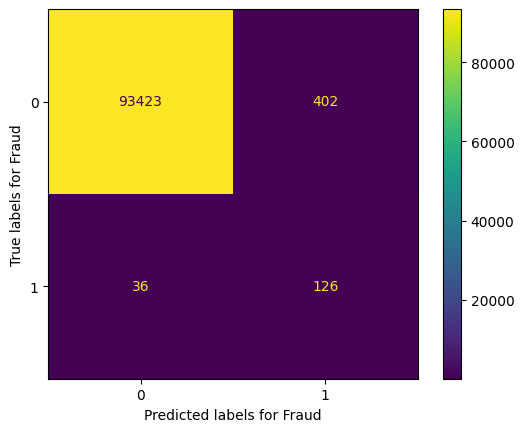

In [77]:
roc_auc = roc_auc_score(y_test, y_xgb_clf_pred)

print("XGBoost Model Evaluation on Test Data:")
print(f"ROC AUC: {roc_auc_score(y_test, y_xgb_clf_pred)}")
print(f'Precision is {precision_score(y_test, y_xgb_clf_pred)}')
print(f'Recall is {recall_score(y_test, y_xgb_clf_pred)}')
print(classification_report(y_test, y_xgb_clf_pred))
cm_xgb = confusion_matrix(y_test, y_xgb_clf_pred)
cmd_xgb = ConfusionMatrixDisplay(cm_xgb)
cmd_xgb.plot()
plt.xlabel('Predicted labels for Fraud')
plt.ylabel('True labels for Fraud')
plt.show()

The XGBoost model achieved a **ROC AUC of 0.8867** on the test data, with a **precision of 0.2386** and a **recall of 0.7778**, indicating strong recall but lower precision.

When dealing with highly imbalanced data, there are some techniques that can prevent the model from being biased toward the majority class and ensure it performs well on the minority class. One of the technique is Resampling.

* Oversampling the minority class: Increase the number of instances in the minority class, either by duplicating existing samples or generating synthetic data points (e.g., SMOTE – Synthetic Minority Over-sampling Technique).
* Undersampling the majority class: Reduce the number of instances in the majority class by randomly removing examples until the classes are balanced.

In [78]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [79]:
# undersampling the majority class

from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply the undersampling technique
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [80]:
dt_pipeline = make_pipeline(
    StandardScaler(),             
    DecisionTreeClassifier(random_state=42, max_depth=3)
)

log_pipeline = make_pipeline(
    StandardScaler(),             
    LogisticRegression(random_state=42)
)

dt_pipeline.fit(X_resampled, y_resampled)  # Fit the decision tree pipeline to the resampled data
log_pipeline.fit(X_resampled, y_resampled) 

# Perform 5-fold cross-validation
dt_scores = cross_val_score(dt_pipeline, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(f'Mean ROC AUC for a decision tree classifier is: {round(dt_scores.mean(), 4)}')

log_scores = cross_val_score(log_pipeline, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(f'Mean ROC AUC using logistic regression is: {round(log_scores.mean(), 4)}')


Mean ROC AUC for a decision tree classifier is: 0.9565
Mean ROC AUC using logistic regression is: 0.9752


In [81]:
y_pred_dt = dt_pipeline.predict(X_test)
y_pred_lr = log_pipeline.predict(X_test)

Decision Tree Evaluation on Test Data:
ROC AUC: 0.918324007460698
Precision is 0.04266263237518911
Recall is 0.8703703703703703
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     93825
           1       0.04      0.87      0.08       162

    accuracy                           0.97     93987
   macro avg       0.52      0.92      0.53     93987
weighted avg       1.00      0.97      0.98     93987



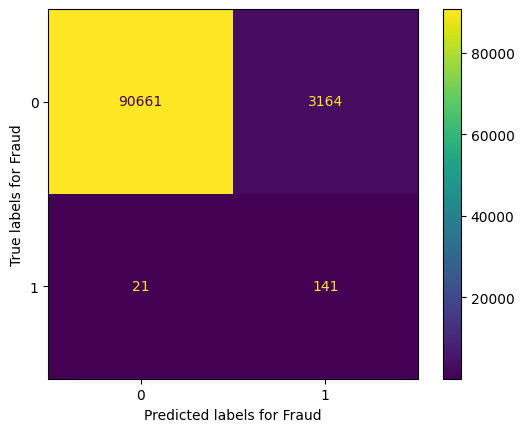

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Decision Tree Evaluation on Test Data:")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_dt)}")
print(f'Precision is {precision_score(y_test, y_pred_dt)}')
print(f'Recall is {recall_score(y_test, y_pred_dt)}')
print(classification_report(y_test, y_pred_dt))
cm_dt = confusion_matrix(y_test, y_pred_dt)
cmd_dt = ConfusionMatrixDisplay(cm_dt)
cmd_dt.plot()
plt.xlabel('Predicted labels for Fraud')
plt.ylabel('True labels for Fraud')
plt.show()



The Decision Tree model achieved a **ROC AUC of 0.9183** on the test data, with a **precision of 0.0427** and a **recall of 0.8704**, indicating high recall but very low precision.


Logistic Regression Evaluation on Test Data:
ROC AUC: 0.9337285726973976
Precision is 0.05301645338208409
Recall is 0.8950617283950617
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     93825
           1       0.05      0.90      0.10       162

    accuracy                           0.97     93987
   macro avg       0.53      0.93      0.54     93987
weighted avg       1.00      0.97      0.98     93987

[[91235  2590]
 [   17   145]]


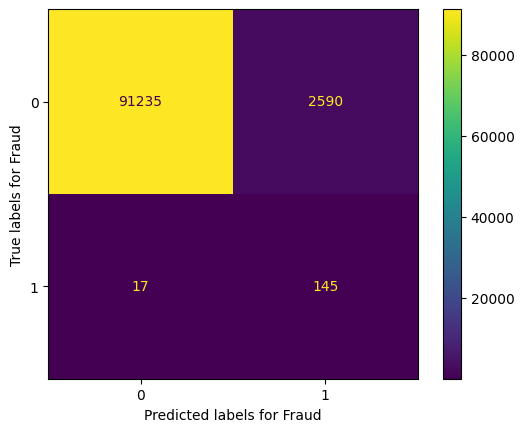

In [84]:
print("\nLogistic Regression Evaluation on Test Data:")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_lr)}")
print(f'Precision is {precision_score(y_test, y_pred_lr)}')
print(f'Recall is {recall_score(y_test, y_pred_lr)}')
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
cm_log = confusion_matrix(y_test, y_pred_lr)
cmd_log = ConfusionMatrixDisplay(cm_log)
cmd_log.plot()
plt.xlabel('Predicted labels for Fraud')
plt.ylabel('True labels for Fraud')
plt.show()

The Logistic Regression model achieved a **ROC AUC of 0.9337**, with a **precision of 0.0530** and a **recall of 0.8951**, indicating strong recall but very low precision.

## Conclusion

Recall is a critical metric since missing fraudulent cases (false negatives) can have serious consequences.

* Logistic Regression achieved the highest ROC AUC (0.9337) and the best recall (0.8951), making it the most effective at identifying fraud cases. However, its precision is extremely low (0.0530), meaning many flagged transactions are false positives.
* Decision Tree also had high recall (0.8704) but even lower precision (0.0427), making it less reliable due to excessive false positives.
* XGBoost had the lowest recall (0.7778) but significantly higher precision (0.2386), reducing false alarms but missing more fraudulent cases.